In [10]:
import sys
import logging
import pickle
import yaml
import matplotlib.cm as cm
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import configs
import seaborn as sns

# Parameters

In [11]:
generic_exp_name = 'new_gridworld8x8'
network_yaml = 'dm'

In [12]:
engram_dir = '/Volumes/aronov-locker/Ching/rl/'
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/' # Axon path

In [13]:
dims = np.arange(2,20)

# Collecting info

In [14]:
models = ['mf0', 'g0_-2_entro-2', 'entro-1']
model_labels = ['MF', 'MF + P/N', 'MF + N']

In [15]:
data = {
    'dims': [],
    'zerofields': [],
    'models': []
}

for model in models:
    for internal_dim in dims:
        exp_name = f'{generic_exp_name}_{network_yaml}_dim{internal_dim}'
        analysis_dir = f'{engram_dir}analysis/{exp_name}/'
        repr_df_path = f'{analysis_dir}representation_df.p'
        if not os.path.exists(repr_df_path):
            continue
        with open(repr_df_path, 'rb') as f:
            repr_df = pickle.load(f)
        _model = f'{generic_exp_name}_{model}'
        model_df = repr_df[repr_df['model'] == _model]
        if model_df.empty:
            continue
        iterations = np.unique(model_df['iteration'])
        for i in iterations:
            _df = model_df[model_df['iteration'] == i]
            width = np.max(_df['x']) + 2
            height = np.max(_df['y']) + 2
            _sample = np.array(_df.head(1)['latents'].item())
            n_units = _sample.size
            heatmap = np.zeros((n_units, width, height))
            for _, row in _df.iterrows():
                x = row['x']
                y = row['y']
                latents = np.array(row['latents'])
                heatmap[:,x,y] = latents
            heatmap[heatmap<0] = 0
            hh = np.sum(heatmap.reshape((internal_dim,-1)), axis=1)
            data['dims'].append(internal_dim)
            data['zerofields'].append(np.sum(hh < 1E-4)/internal_dim)
            data['models'].append(model)

# Measuring collapse

In [16]:
import pandas as pd

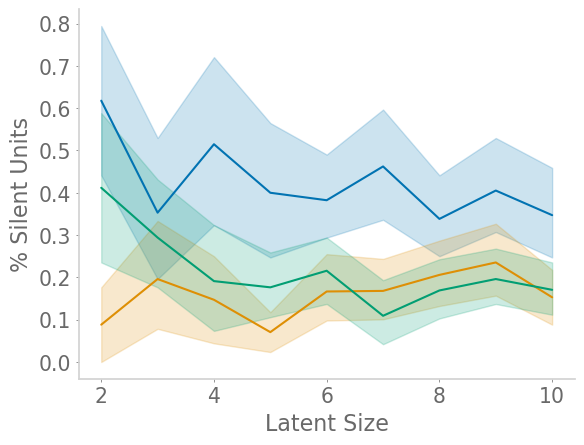

In [8]:
fig, ax = plt.subplots()
sns.lineplot(
    x='dims', y='zerofields', data=pd.DataFrame(data),
    hue='models', hue_order=models, ax=ax, legend=None
    )
ax.set_ylabel('% Silent Units')
ax.set_xlabel('Latent Size')

# Replace legend names
label_list = []
for t in ax.get_legend_handles_labels():
    label_list.append(t)
label_list[1] = model_labels
#ax.legend(handles=label_list[0], labels=label_list[1])

Text(0.5, 0, 'Latent Size')

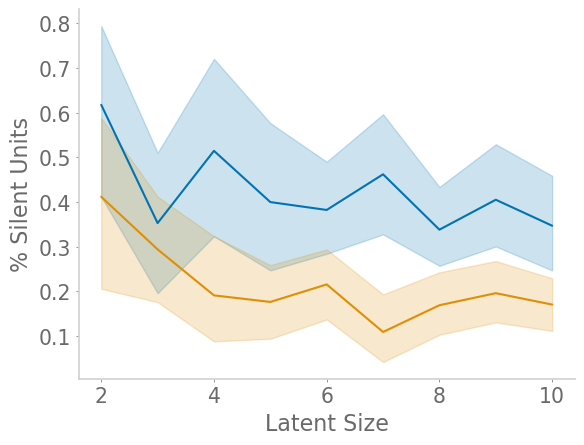

In [9]:
fig, ax = plt.subplots()
sns.lineplot(
    x='dims', y='zerofields', data=pd.DataFrame(data),
    hue='models', hue_order=[models[0], models[2]], ax=ax, legend=None
    )
ax.set_ylabel('% Silent Units')
ax.set_xlabel('Latent Size')

# Replace legend names
# label_list = []
# for t in ax.get_legend_handles_labels():
#     label_list.append(t)
# label_list[1] = model_labels
#ax.legend(handles=label_list[0], labels=label_list[1])

In [18]:
df = pd.DataFrame(data)

In [21]:
from scipy.stats import sem

In [28]:
def smooth(xs, ys, n=3):
    return np.convolve(ys, np.ones(n)/n, mode='same')

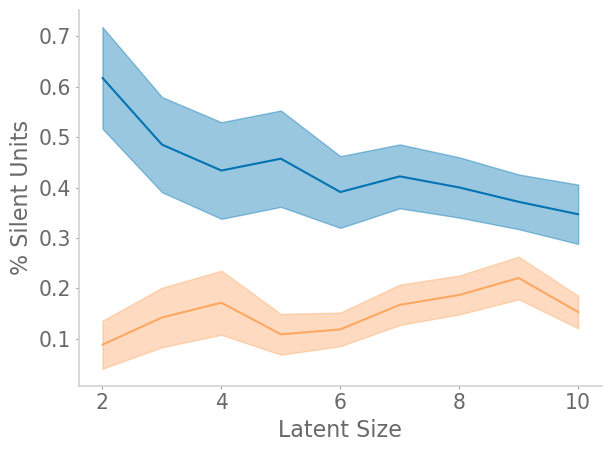

In [33]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', colors(c_steps[0])]
smooth_line = True
fig, ax = plt.subplots()
for _idx, model in enumerate([
     'mf0', 'g0_-2_entro-2'
    ]):
    means = []
    sems = []
    for d in np.arange(2,11):
        r = df[(df['models']==model) & (df['dims']==d)]
        zerofields = r['zerofields']
        means.append(np.mean(zerofields))
        sems.append(sem(zerofields))
    means = np.array(means)
    sems = np.array(sems)
    if smooth_line:
        means[1:-1] = smooth(np.arange(2,11), means, 2)[1:-1]
        sems[1:-1] = smooth(np.arange(2,11), np.array(sems), 2)[1:-1]
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    ax.plot(np.arange(2,11), means, label=model, color=colors[_idx])
    ax.fill_between(
        np.arange(2,11), mean_lowerbound,
        mean_upperbound, alpha=0.4, color=colors[_idx])
plt.ylabel('% Silent Units')
plt.xlabel('Latent Size')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()